# Dropout Placement Analysis in ResNet for CIFAR-100

This notebook trains ResNet-18 models on CIFAR-100 with four different dropout placements:
1. Standard (after ReLU)
2. Pre-ReLU (before activation)
3. Post-Addition (after skip connection)
4. Mixed (pre-ReLU + post-addition)

We evaluate Top-1/Top-5 accuracy, loss curves, calibration (ECE), and Hessian-based flatness.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Model definitions

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, out_planes, stride=1, dropout_rate=0.3, variant='standard', downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, out_planes, stride)
        self.bn1   = nn.BatchNorm2d(out_planes)
        self.conv2 = conv3x3(out_planes, out_planes)
        self.bn2   = nn.BatchNorm2d(out_planes)
        self.downsample = downsample
        self.dropout_rate = dropout_rate
        self.variant = variant
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        if self.variant in ['pre-relu', 'mixed']:
            out = F.dropout(out, p=self.dropout_rate, training=self.training)
        out = F.relu(out)
        if self.variant == 'standard':
            out = F.dropout(out, p=self.dropout_rate, training=self.training)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        if self.variant in ['post-addition', 'mixed']:
            out = F.dropout(out, p=self.dropout_rate, training=self.training)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=100, dropout_rate=0.3, variant='standard'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(self.in_planes)
        self.relu  = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1, dropout_rate=dropout_rate, variant=variant)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_rate=dropout_rate, variant=variant)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_rate=dropout_rate, variant=variant)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_rate=dropout_rate, variant=variant)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
    def _make_layer(self, block, out_planes, blocks, stride, dropout_rate, variant):
        downsample = None
        if stride != 1 or self.in_planes != out_planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, out_planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes * block.expansion),
            )
        layers = [block(self.in_planes, out_planes, stride, dropout_rate, variant, downsample)]
        self.in_planes = out_planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, out_planes, 1, dropout_rate, variant))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def create_resnet18(variant):
    return ResNet(BasicBlock, [2,2,2,2], num_classes=100, dropout_rate=0.3, variant=variant).to(device)

In [3]:
# Dataset and DataLoader

mean = (0.5071, 0.4867, 0.4408)
std  = (0.2675, 0.2565, 0.2761)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_set = torchvision.datasets.CIFAR100('./data', train=True, download=True, transform=train_transform)
test_set  = torchvision.datasets.CIFAR100('./data', train=False, download=True, transform=test_transform)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Training and Evaluation Loop

import time
from collections import defaultdict

variants = ['standard', 'pre-relu', 'post-addition', 'mixed']
results = {}

for var in variants:
    print(f"Training variant: {var}")
    model = create_resnet18(var)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [50,75], gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    history = defaultdict(list)
    for epoch in range(1, 101):
        # Training
        model.train()
        running_loss = 0.0
        correct1 = 0; correct5 = 0; total = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, pred = outputs.topk(5, 1)
            total += targets.size(0)
            correct1 += (pred[:,0] == targets).sum().item()
            correct5 += sum([1 for i in range(targets.size(0)) if targets[i].item() in pred[i].tolist()])
        train_loss = running_loss / total
        train_acc1 = correct1 / total * 100
        train_acc5 = correct5 / total * 100
        # Evaluation
        model.eval()
        running_loss = 0.0
        correct1 = 0; correct5 = 0; total = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_loss += loss.item() * inputs.size(0)
                _, pred = outputs.topk(5, 1)
                total += targets.size(0)
                correct1 += (pred[:,0] == targets).sum().item()
                correct5 += sum([1 for i in range(targets.size(0)) if targets[i].item() in pred[i].tolist()])
        test_loss = running_loss / total
        test_acc1 = correct1 / total * 100
        test_acc5 = correct5 / total * 100
        scheduler.step()
        # Log
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['train_acc1'].append(train_acc1)
        history['train_acc5'].append(train_acc5)
        history['test_loss'].append(test_loss)
        history['test_acc1'].append(test_acc1)
        history['test_acc5'].append(test_acc5)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Test Top1={test_acc1:.2f}%")
    results[var] = history

Training variant: standard
Epoch 10: Test Top1=49.93%
Epoch 20: Test Top1=54.73%
Epoch 30: Test Top1=57.12%
Epoch 40: Test Top1=55.87%
Epoch 50: Test Top1=58.41%
Epoch 60: Test Top1=74.66%
Epoch 70: Test Top1=74.11%
Epoch 80: Test Top1=75.64%
Epoch 90: Test Top1=76.29%
Epoch 100: Test Top1=76.04%
Training variant: pre-relu
Epoch 10: Test Top1=50.93%
Epoch 20: Test Top1=56.38%
Epoch 30: Test Top1=58.80%
Epoch 40: Test Top1=58.29%
Epoch 50: Test Top1=59.23%
Epoch 60: Test Top1=74.38%
Epoch 70: Test Top1=73.91%
Epoch 80: Test Top1=75.98%
Epoch 90: Test Top1=75.89%
Epoch 100: Test Top1=75.88%
Training variant: post-addition
Epoch 10: Test Top1=46.06%
Epoch 20: Test Top1=51.56%
Epoch 30: Test Top1=51.73%
Epoch 40: Test Top1=52.65%
Epoch 50: Test Top1=51.26%
Epoch 60: Test Top1=72.35%
Epoch 70: Test Top1=72.45%
Epoch 80: Test Top1=74.36%
Epoch 90: Test Top1=74.65%
Epoch 100: Test Top1=74.80%
Training variant: mixed
Epoch 10: Test Top1=42.27%
Epoch 20: Test Top1=51.86%
Epoch 30: Test Top1=50.

In [11]:
for var in variants:
    print(results[var])
    print()


defaultdict(<class 'list'>, {'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], 'train_loss': [3.9798020026397705, 3.406280982589722, 2.966778013153076, 2.5724664949035643, 2.2864580919647217, 2.092268387718201, 1.953118076171875, 1.8393058306884766, 1.7534704775619507, 1.6890493767547607, 1.6350221272659302, 1.5930817053985595, 1.550399063720703, 1.5221171671295166, 1.5019148011779786, 1.4768169371032716, 1.448371704750061, 1.4283442378234863, 1.4188835883331299, 1.3997291590499878, 1.377905412712097, 1.3760203393936157, 1.3663911862945557, 1.3512358283233643, 1.345975630607605, 1.3311021734237671, 1.3312786354827881, 1.3124159550476073, 1

In [23]:
for var in variants:
    print(var)
    for i in ['epoch', 'train_loss', 'train_acc1', 'train_acc5', 'test_loss', 'test_acc1', 'test_acc5']:
        print(i)
        print(results[var][i][90:100])
    print()

standard
epoch
[91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
train_loss
[0.0896543832230568, 0.08788185403347015, 0.08579226806640625, 0.08291299441099167, 0.08356224812030792, 0.07957127023816109, 0.07840511259555817, 0.07936734193086624, 0.07732544225692749, 0.07806003528356552]
train_acc1
[98.068, 98.142, 98.244, 98.332, 98.226, 98.382, 98.4, 98.36, 98.426, 98.41]
train_acc5
[99.992, 99.988, 99.994, 99.984, 99.98599999999999, 99.996, 99.992, 99.99, 99.992, 99.992]
test_loss
[0.9859198976516723, 0.992287194442749, 0.9926563884735108, 0.9889198509216308, 0.9962497690200806, 0.9989129325866699, 1.002308455657959, 0.9966822164535523, 1.003813704109192, 1.00236016998291]
test_acc1
[76.13, 75.94999999999999, 75.94, 75.94, 76.05, 76.07000000000001, 75.81, 75.97, 75.9, 76.03999999999999]
test_acc5
[93.63, 93.69, 93.81, 93.84, 93.69, 93.67999999999999, 93.75, 93.78999999999999, 93.67999999999999, 93.77]

pre-relu
epoch
[91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
train_loss
[0.08827370021343231, 0.

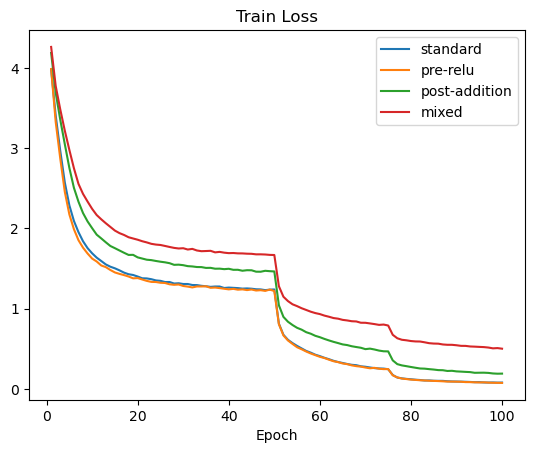

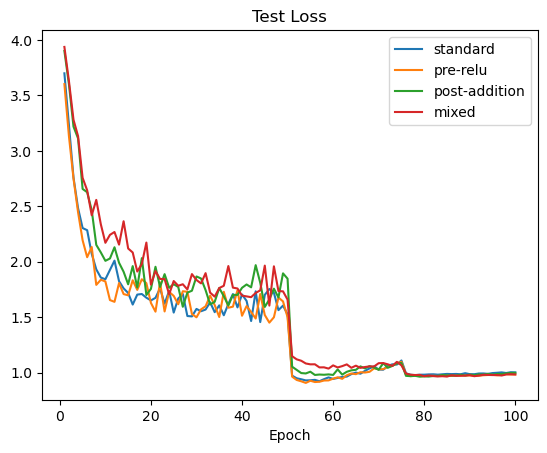

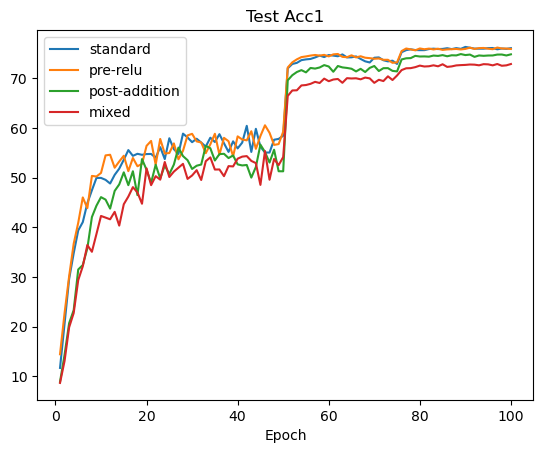

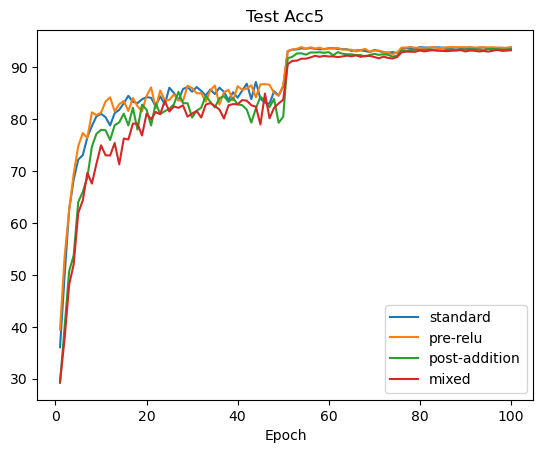

In [7]:
# Plotting Results

for metric in ['train_loss', 'test_loss', 'test_acc1', 'test_acc5']:
    plt.figure()
    for var in variants:
        plt.plot(results[var]['epoch'], results[var][metric], label=var)
    plt.title(metric.replace('_', ' ').title())
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

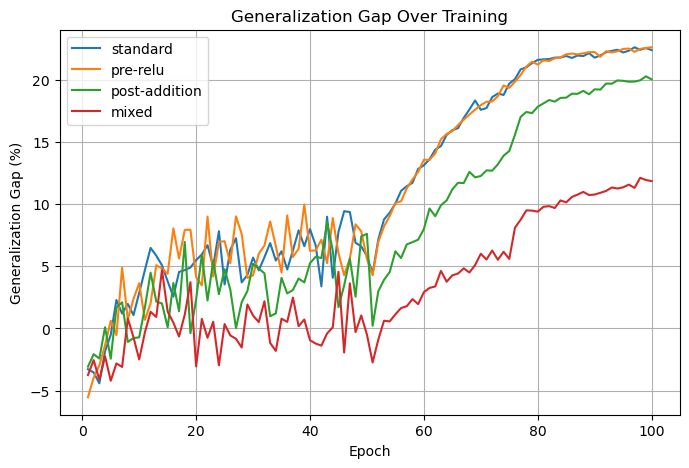

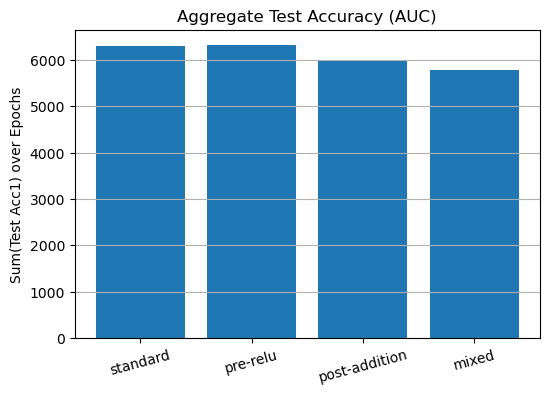

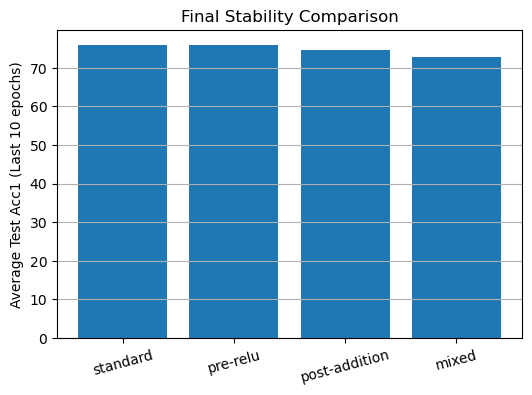

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assume `results` is a dict mapping variant name to its history dict, e.g.:
# results = {
#     'standard': {'epoch': [...], 'train_acc1': [...], 'test_acc1': [...], ...},
#     'pre-relu': {...},
#     'post-addition': {...},
#     'mixed': {...}
# }

variants = ['standard', 'pre-relu', 'post-addition', 'mixed']

# 1) Generalization Gap: train_acc1 - test_acc1 over epochs
plt.figure(figsize=(8,5))
for var in variants:
    hist = results[var]
    gap = np.array(hist['train_acc1']) - np.array(hist['test_acc1'])
    plt.plot(hist['epoch'], gap, label=var)
plt.xlabel('Epoch')
plt.ylabel('Generalization Gap (%)')
plt.title('Generalization Gap Over Training')
plt.legend()
plt.grid(True)
plt.show()

# 2) Aggregate Test Accuracy (Area Under Curve)
auc_scores = {}
for var in variants:
    hist = results[var]
    auc_scores[var] = np.trapz(hist['test_acc1'], hist['epoch'])  # approximate integral

plt.figure(figsize=(6,4))
plt.bar(auc_scores.keys(), auc_scores.values())
plt.ylabel('Sum(Test Acc1) over Epochs')
plt.title('Aggregate Test Accuracy (AUC)')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()

# 3) Stability: Average Test Acc1 over last 10 epochs
avg_last10 = {}
for var in variants:
    hist = results[var]
    avg_last10[var] = np.mean(hist['test_acc1'][-10:])

plt.figure(figsize=(6,4))
plt.bar(avg_last10.keys(), avg_last10.values())
plt.ylabel('Average Test Acc1 (Last 10 epochs)')
plt.title('Final Stability Comparison')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()
